# **MRI Image Analysis for Brain Tumor Detection and Classification using Deep Learning**



**Mounting Google Drive**

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


**Importing Required Libraries**

In [7]:
import sys
import os
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *

print(f'Tensorflow Version: {tf.__version__}.')

Tensorflow Version: 2.17.0.


**Installation of `tree` Utility Using `Bash`. and Look up the File Structure**  

In [8]:
%%bash
RED_COLOR='\033[0;31m'
NO_COLOR='\033[0m'
pkg_name=tree
dpkg -s $pkg_name &> /dev/null
if [ "$?" -ne "0" ]
    then
        echo "Installing tree utility..."
        apt-get autoclean
        apt-get autoremove
        apt-get install $pkg_name
        if [ "$?" -eq "0" ]
            then
                echo -e ${RED_COLOR}"tree utility installed sucessfully.\n"${NO_COLOR}
        fi
    else
        echo "tree utility is already installed."
fi
tree --version

Installing tree utility...
Reading package lists...
Building dependency tree...
Reading state information...
Reading package lists...
Building dependency tree...
Reading state information...
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (65.8 kB/s)
Selecting previously unselected package tree.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
tree utility installed sucessfully.

tree v2.0.

In [9]:
!tree -d "/content/gdrive/MyDrive/Project/Brain Tumor Data"

/content/gdrive/MyDrive/Project/Brain Tumor Data
├── Model-Checkpoints
│   ├── AlexNet-CNN
│   ├── InceptionV3
│   └── Multi-Layer-Perceptron
├── Testing
│   ├── No
│   └── Yes
├── Training
│   ├── glioma
│   ├── meningioma
│   ├── no_tumor
│   └── pituitary_tumor
└── Tumor-Mask
    ├── glioma
    ├── meningioma
    └── pituitary_tumor

16 directories


**Setting Up all the Paths to Root and Data Directories**

In [10]:
ROOT_DIR = r"/content/gdrive/MyDrive/Project/"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "Brain Tumor Data")
TRAIN_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
MASK_DIR = os.path.join(DATA_ROOT_DIR, 'Tumor-Mask')
assert os.path.isdir(ROOT_DIR) and os.path.isdir(DATA_ROOT_DIR) and os.path.isdir(TRAIN_DIR) and os.path.isdir(MASK_DIR)
TUMOR_CLASS = ['meningioma', 'glioma', 'pituitary_tumor', 'no_tumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASS]
MASK_DATA_PATHS = [os.path.join(MASK_DIR, tumor_name) for tumor_name in TUMOR_CLASS[:-1]]

**Data Preprocessing and Exploratory Data Analysis to get better understanding**

In [11]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],
                                    index = TUMOR_CLASS)
data_distribution_count

,0
meningioma,708
glioma,1424
pituitary_tumor,930
no_tumor,395


**Data Distribution Visualization**

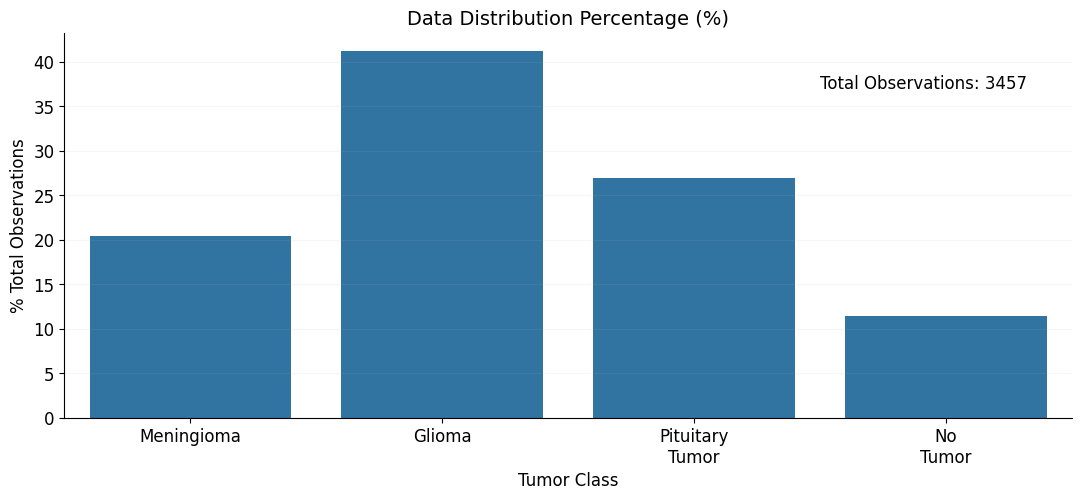

In [14]:
fig, axis = plt.subplots(figsize = (13, 5))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 14)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y = 100 * (data_distribution_count / data_distribution_count.sum()), ax = axis)
axis.set_xlabel("Tumor Class", fontsize = 12)
axis.set_ylabel("% Total Observations", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()

### **Visualisation of Brain MRI Dataset**

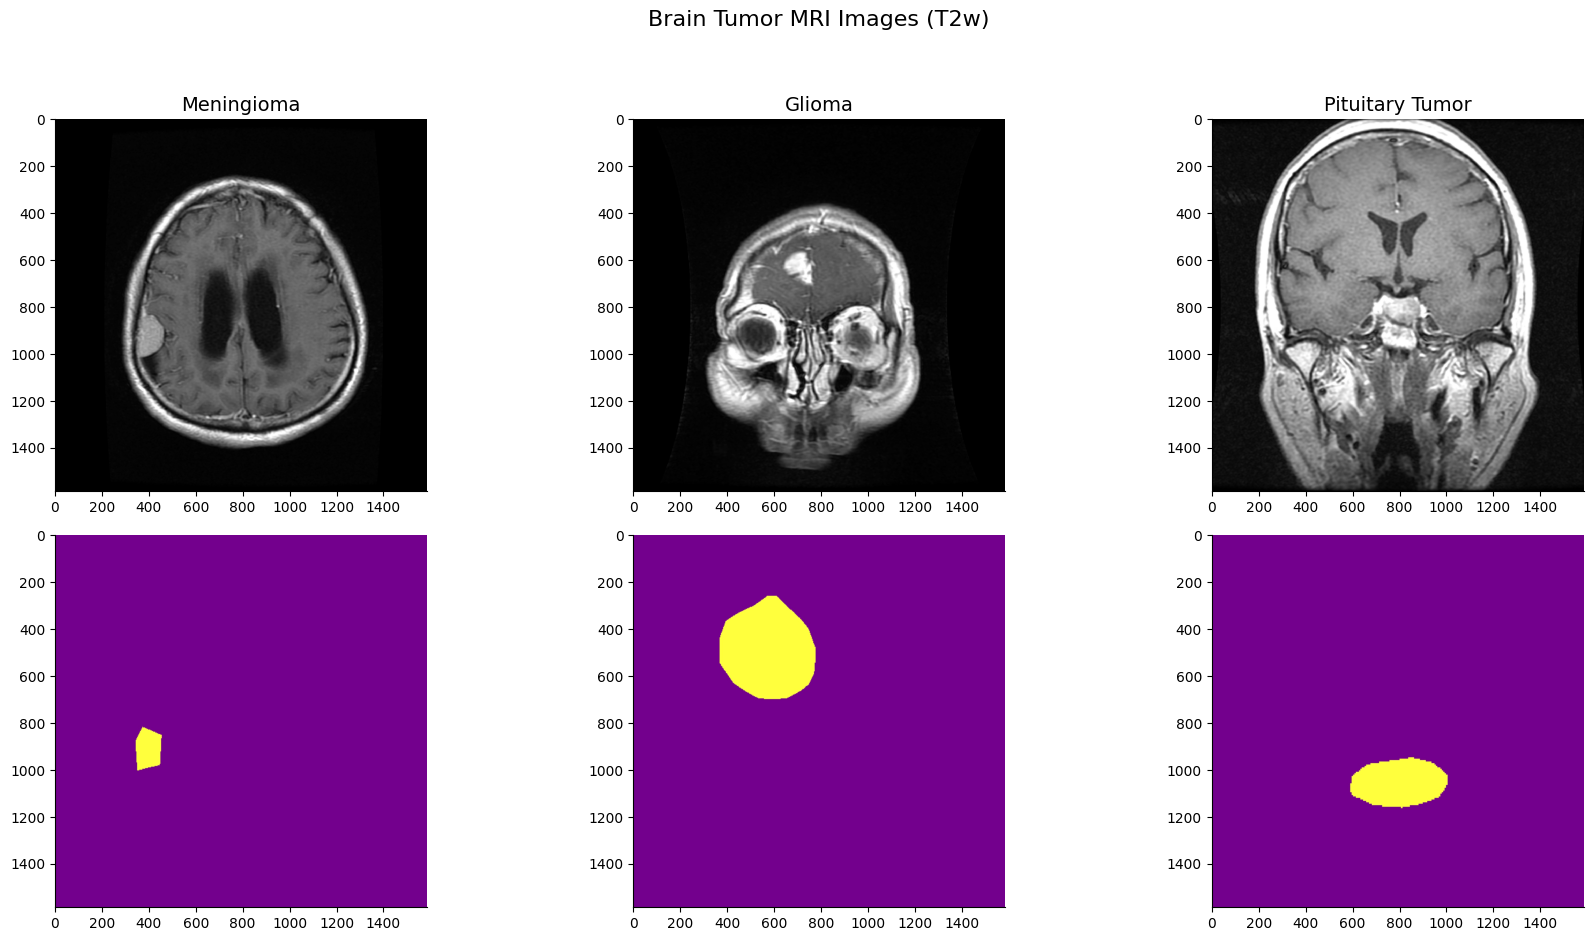

In [15]:
BRIGHTNESS_FACTOR = 1.7
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 9))
axes = axes.flatten()
fig.suptitle("Brain Tumor MRI Images (T2w)", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.04)
for curr_title, filename, curr_axis in zip(TUMOR_CLASS[:-1], IMAGE_DATA_PATHS[:-1], axes[:3]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    img_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(img_enhancer.enhance(BRIGHTNESS_FACTOR))
    curr_axis.set_title(" ".join(curr_title.split('_')).title(), fontsize = 14)

for filename, curr_axis in zip(MASK_DATA_PATHS, axes[3:]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    mask_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(mask_enhancer.enhance(BRIGHTNESS_FACTOR))
fig.tight_layout()
sns.despine()

### **Split into Train, Test and Validation**

In [16]:
image_data_paths = []
for curr_path, tumor_name in zip(IMAGE_DATA_PATHS, TUMOR_CLASS):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        image_data_paths.extend(map(lambda filename: (os.path.join(curr_path, filename), tumor_name), os.listdir(curr_path)))

In [17]:
image_data_paths_df = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
image_data_paths_df.head()

,image_filepaths,tumor_class
0,/content/gdrive/MyDrive/Project/Brain Tumor Da...,glioma
1,/content/gdrive/MyDrive/Project/Brain Tumor Da...,meningioma
2,/content/gdrive/MyDrive/Project/Brain Tumor Da...,meningioma
3,/content/gdrive/MyDrive/Project/Brain Tumor Da...,pituitary_tumor
4,/content/gdrive/MyDrive/Project/Brain Tumor Da...,glioma


In [18]:
image_data_paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3457 entries, 0 to 3456
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_filepaths  3457 non-null   object
 1   tumor_class      3457 non-null   object
dtypes: object(2)
memory usage: 54.1+ KB


In [19]:
intermediate_train_data, test_data = train_test_split(image_data_paths_df,
                                                      train_size = 0.70,
                                                      random_state = 42,
                                                      stratify = image_data_paths_df.tumor_class)

train_data, validation_data = train_test_split(intermediate_train_data,
                                               train_size = 0.80,
                                               random_state = 42,
                                               stratify = intermediate_train_data.tumor_class)

## **Data Distribution Visualization of Train, Test and Validation Data**

<ipython-input-20-2c041b460a71>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_data.tumor_class, order=TUMOR_CLASS, ax=axes[0], palette="Set2")
<ipython-input-20-2c041b460a71>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=validation_data.tumor_class, order=TUMOR_CLASS, ax=axes[1], palette="husl")
<ipython-input-20-2c041b460a71>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=test_data.tumor_class, order=TUMOR_CLASS, ax=axes[2], palette="flare")
<ipython-input-20-2c041b460a71>:7: UserWarning: First parameter to grid() 

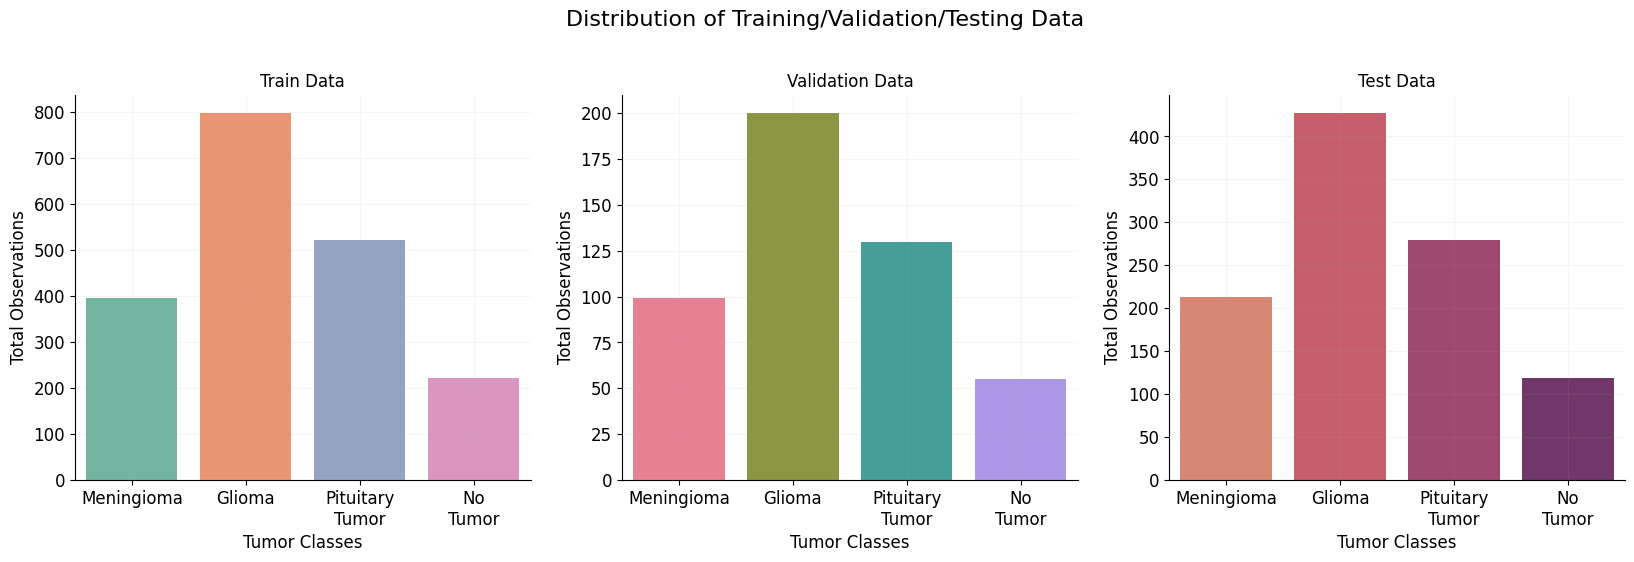

In [20]:
fig, axes = plt.subplots(ncols = 3, figsize = (20, 5))
fig.suptitle("Distribution of Training/Validation/Testing Data", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.05)
sns.countplot(x=train_data.tumor_class, order=TUMOR_CLASS, ax=axes[0], palette="Set2")
sns.countplot(x=validation_data.tumor_class, order=TUMOR_CLASS, ax=axes[1], palette="husl")
sns.countplot(x=test_data.tumor_class, order=TUMOR_CLASS, ax=axes[2], palette="flare")
for curr_axis, curr_title in zip(axes, ['Train Data', 'Validation Data', 'Test Data']):
    curr_axis.grid(False, alpha = 0.1)
    curr_axis.set_title(curr_title, fontsize = 12)
    curr_axis.set_xlabel("Tumor Classes", fontsize = 12)
    curr_axis.set_ylabel("Total Observations", fontsize = 12)
    curr_axis.tick_params(which = 'major', labelsize = 12)
    curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASS])
sns.despine()

## **Data Augmentation**

In [21]:
image_size = 224
batch_size = 32

image_datagen_kwargs = dict(rescale = 1 / 255,
                            rotation_range = 15,
                            width_shift_range = 0.1,
                            zoom_range = 0.01,
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.5],
                            horizontal_flip = True,
                            vertical_flip = True)

In [22]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
test_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

In [23]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data,
                                                                  x_col = 'image_filepaths',
                                                                  y_col = 'tumor_class',
                                                                  seed = 42,
                                                                  batch_size = batch_size,
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')
test_dataset = test_image_datagen.flow_from_dataframe(test_data,
                                                      x_col = 'image_filepaths',
                                                      y_col = 'tumor_class',
                                                      seed = 42,
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 1935 validated image filenames belonging to 4 classes.
Found 484 validated image filenames belonging to 4 classes.
Found 1038 validated image filenames belonging to 4 classes.


In [24]:
print("Information about Training Dataset:")
print(train_dataset.class_indices)
print(train_dataset.image_shape, end = '\n\n')

print("Information about Validation Dataset:")
print(validation_dataset.class_indices)
print(validation_dataset.image_shape, end = '\n\n')

print("Information about Testing Dataset:")
print(test_dataset.class_indices)
print(test_dataset.image_shape)

Information about Training Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(224, 224, 3)

Information about Validation Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(224, 224, 3)

Information about Testing Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(224, 224, 3)


### **Visualization of Training Data**

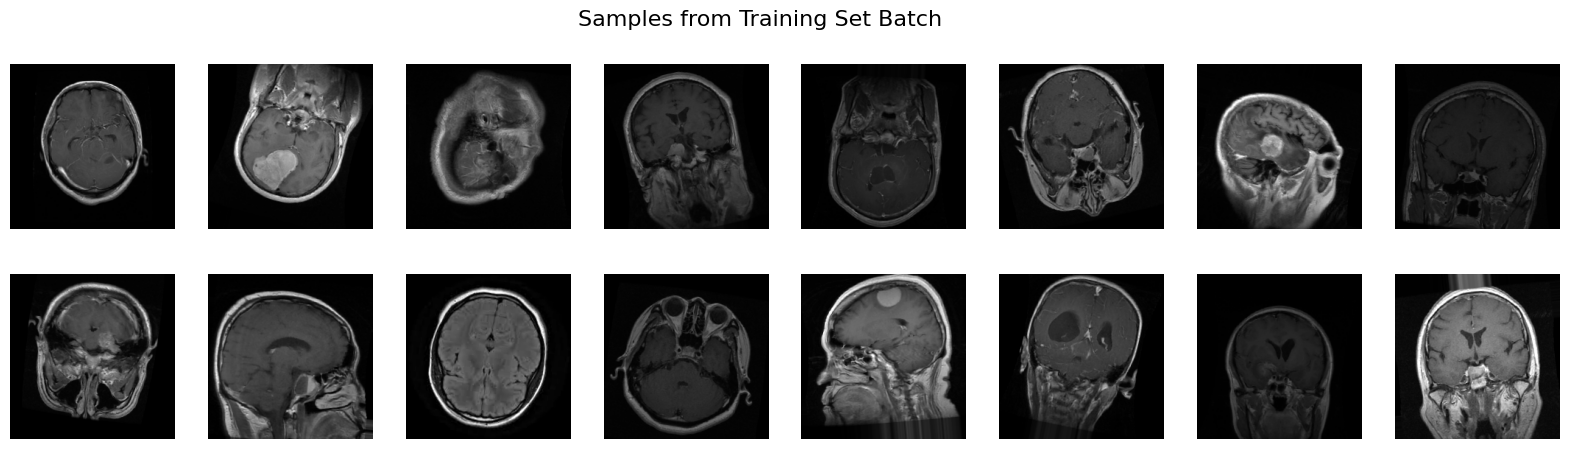

In [25]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Training Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), train_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

### **Visualization of Validation Data**

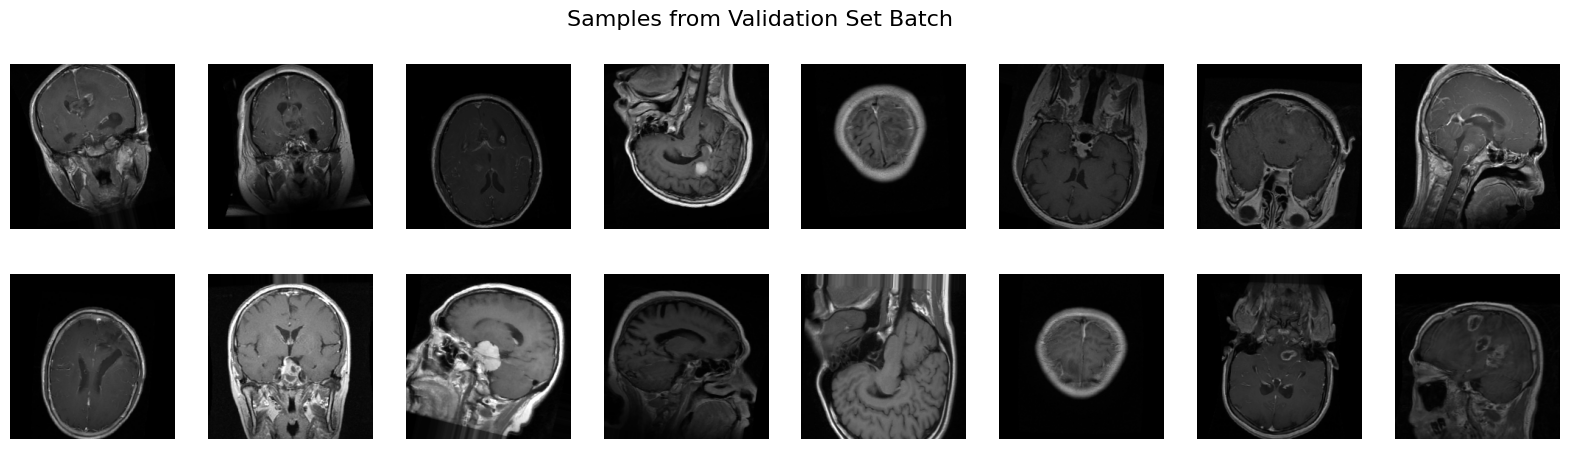

In [26]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Validation Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), validation_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

### **Visualization of Testing Data**

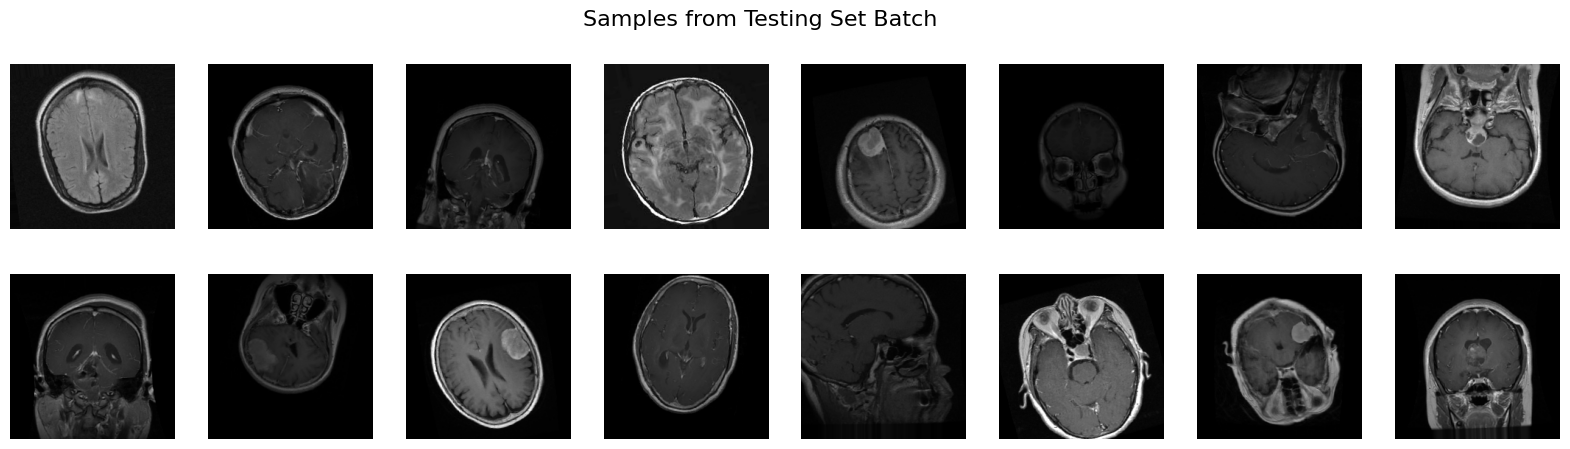

In [27]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Testing Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), test_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

## **Model Development**

In [28]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)

In [29]:
import os

ROOT_CHECKPOINT_DIR_PATH = os.path.join(ROOT_DIR, "Model-Checkpoints")
MLP_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "Multi-Layer-Perceptron")
ALEXNET_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "AlexNet-CNN")
INCEPTIONV3_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "InceptionV3")

# Create the directories if they don't exist
for dir_path in [ROOT_CHECKPOINT_DIR_PATH, MLP_CHECKPOINT_DIR_PATH, ALEXNET_CHECKPOINT_DIR_PATH, INCEPTIONV3_CHECKPOINT_DIR_PATH]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Now the assertion should pass
assert os.path.isdir(ROOT_CHECKPOINT_DIR_PATH) and os.path.isdir(MLP_CHECKPOINT_DIR_PATH) and os.path.isdir(ALEXNET_CHECKPOINT_DIR_PATH) and os.path.isdir(INCEPTIONV3_CHECKPOINT_DIR_PATH)

In [30]:
mlp_cp_callback = ModelCheckpoint(os.path.join(MLP_CHECKPOINT_DIR_PATH, 'model.weights.h5'), # append 'model.weights.h5' to the directory path
                                  monitor = 'val_accuracy',
                                  verbose = 1,
                                  save_weights_only = True,
                                  save_freq =  'epoch')

alexnet_cp_callback = ModelCheckpoint(os.path.join(ALEXNET_CHECKPOINT_DIR_PATH, 'model.weights.h5'), # append 'model.weights.h5' to the directory path
                                      monitor = 'val_accuracy',
                                      verbose = 1,
                                      save_weights_only = True,
                                      save_freq = 'epoch')

inceptionv3_cp_callback = ModelCheckpoint(os.path.join(INCEPTIONV3_CHECKPOINT_DIR_PATH, 'model.weights.h5'), # append 'model.weights.h5' to the directory path
                                          monitor = 'val_accuracy',
                                          verbose = 1,
                                          save_weights_only = True,
                                          save_freq = 'epoch')

In [31]:
def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()

In [32]:
def confusion_matrix_viz(model, test_dataset, **plot_kwargs) -> None:
    assert isinstance(model, Sequential)
    model_preds = [np.argmax(curr_row) for curr_row in model.predict(test_dataset)]
    fig, axis = plt.subplots(figsize = (8, 6))
    class_names = ['Glioma', 'Meningioma', 'No-Tumor', 'Pituitary\nTumor']
    sns.heatmap(confusion_matrix(test_dataset.classes, model_preds), annot = True, cmap = plt.cm.Reds, ax = axis)
    axis.set_title(plot_kwargs['plot_title'], fontsize = 14)
    axis.tick_params(which = 'major', labelsize = 12)
    axis.set_xlabel("Pedicted Class", fontsize = 12)
    axis.set_ylabel("Actual Class", fontsize = 12)
    axis.set_xticklabels(class_names, fontdict = dict(fontsize = 12))
    axis.set_yticklabels(class_names, fontdict = dict(fontsize = 12))
    fig.tight_layout()
    sns.despine()

In [33]:
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE', 'Loss', 'Accuracy', 'F1-Score'])
    y_hat = test_dataset.classes # y_hat = ground_truth
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        curr_model_loss, curr_model_accuracy = curr_model.evaluate(test_dataset)
        y_preds = [np.argmax(curr_preds) for curr_preds in curr_model.predict(test_dataset)]
        report_df.loc[curr_index] = [mean_absolute_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds, squared = False), curr_model_loss, curr_model_accuracy, f1_score(y_hat, y_preds, average = "micro")]
    report_df.index = row_indexes
    return report_df

## **Multi-Layer Perceptron**

In [34]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape = (image_size, image_size, 3), name = 'Flatten-Layer'))
mlp_model.add(Dense(2048, activation = 'relu', name = 'Hidden-Layer-1'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-1'))
mlp_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-2'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-2'))
mlp_model.add(Dense(512, activation = 'relu', name = 'Hidden-Layer-3'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-3'))
mlp_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer-1'))
mlp_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
mlp_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten-Layer (Flatten)              │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 2048)                │     308,283,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout-Layer-1 (Dropout)            │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-2 (Dense)               │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout-Layer-2 (Dropout)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-3 (Dense)               │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout-Layer-3 (Dropout)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer-1 (Dense)               │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,908,420 (1.16 GB)

 Trainable params: 310,908,420 (1.16 GB)

 Non-trainable params: 0 (0.00 B)

**Training and Validation of Multi-Layer Perceptron Model**

In [35]:
mlp_train_history = mlp_model.fit(train_dataset,
                                      batch_size = batch_size,
                                      validation_data = validation_dataset,
                                      epochs = 100,
                                      callbacks = [early_stopping])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 946s 14s/step - accuracy: 0.3529 - loss: 25.3727 - val_accuracy: 0.5537 - val_loss: 1.3398
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 653s 10s/step - accuracy: 0.4543 - loss: 1.5186 - val_accuracy: 0.3864 - val_loss: 1.2269
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 618s 10s/step - accuracy: 0.4546 - loss: 1.3072 - val_accuracy: 0.5702 - val_loss: 1.1976
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 621s 10s/step - accuracy: 0.5007 - loss: 1.2257 - val_accuracy: 0.6033 - val_loss: 1.1389
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 632s 10s/step - accuracy: 0.5196 - loss: 1.1844 - val_accuracy: 0.5930 - val_loss: 1.0775
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 621s 10s/step - accuracy: 0.5501 - loss: 1.1385 - val_accuracy: 0.5702 - val_loss: 1.1114
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 616s 10s/step - accuracy: 0.5515 - loss: 1.1244 - val_accuracy: 0.5702 - val_loss: 1.1121
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 607s 10s/step - accuracy: 0.5647 - loss: 1.1046 - val_accuracy: 0.566

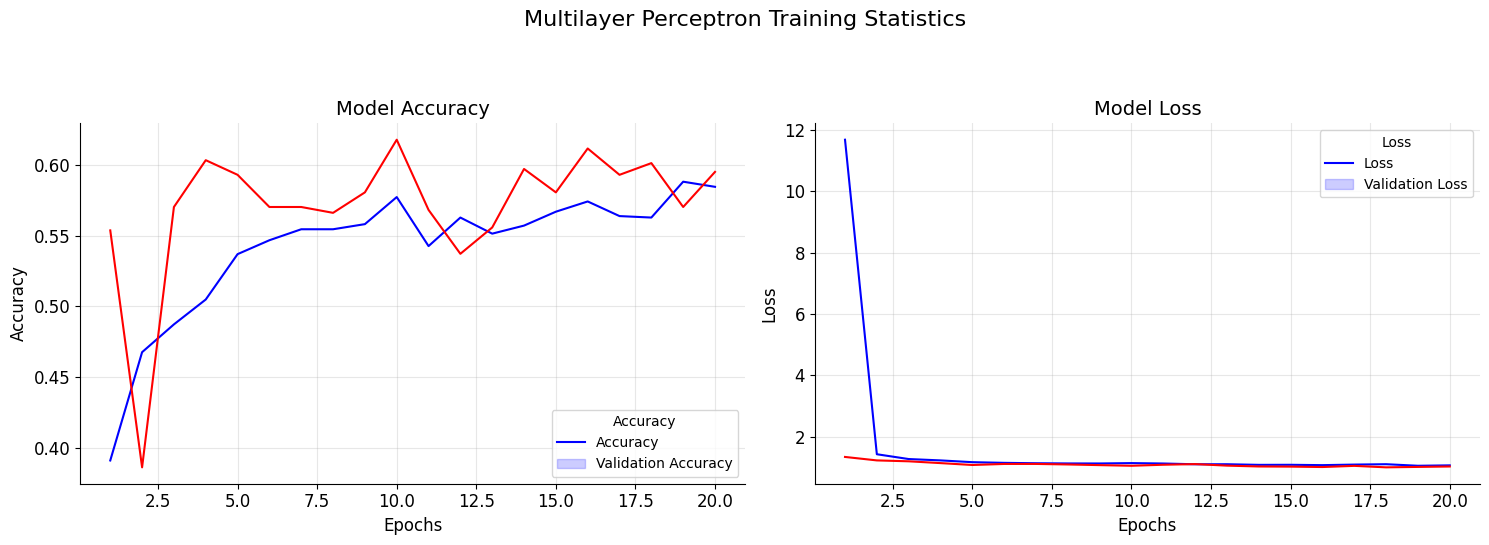

In [36]:
training_process_viz(pd.DataFrame(mlp_train_history.history),
                     plot_title = 'Multilayer Perceptron Training Statistics')

61/61 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step


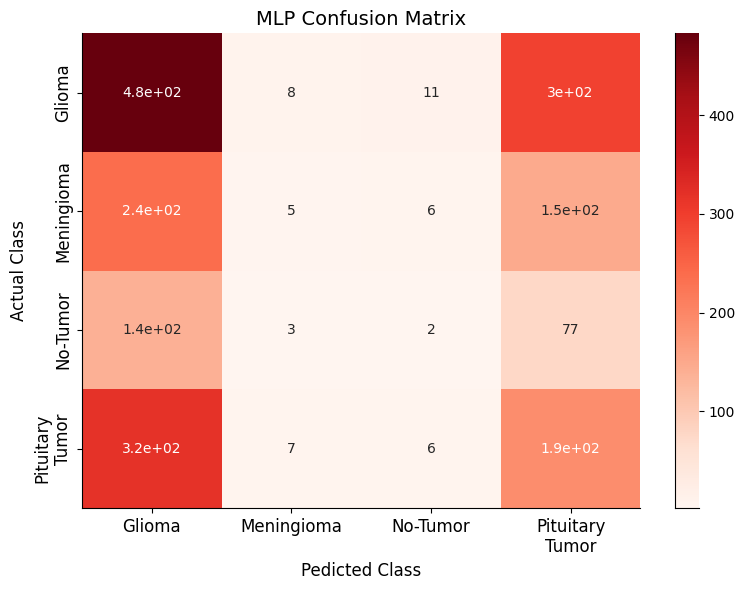

In [37]:
confusion_matrix_viz(mlp_model, train_dataset, plot_title = "MLP Confusion Matrix")

In [38]:
mlp_report_df = generate_report(mlp_model,
                                test_dataset = test_dataset,
                                row_indexes = ("Multi-Layer-Perceptron Model",))
mlp_report_df

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 313s 10s/step - accuracy: 0.5898 - loss: 1.0306
33/33 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
Multi-Layer-Perceptron Model,1.374759,3.471098,1.863088,1.00868,0.61079,0.372832


## **AlexNet CNN**

In [39]:
alexnet_cnn = Sequential()
alexnet_cnn.add(Conv2D(96, kernel_size = 11, strides = 4, activation = 'relu', input_shape = (image_size, image_size, 3), name = 'Conv2D-1'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-1'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-1'))
alexnet_cnn.add(Conv2D(256, kernel_size = 5, padding = 'same', activation = 'relu', name = 'Conv2D-2'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-2'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-2'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-3'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-3'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-4'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-4'))
alexnet_cnn.add(Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-5'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-5'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-3'))
alexnet_cnn.add(Flatten(name = 'Flatten-Layer-1'))
alexnet_cnn.add(Dense(128, activation = 'relu', name = 'Hidden-Layer-1'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-1'))
alexnet_cnn.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-2'))
alexnet_cnn.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
alexnet_cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
alexnet_cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv2D-1 (Conv2D)                    │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch-Normalization-1                │ (None, 54, 54, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max-Pooling-1 (MaxPooling2D)         │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D-2 (Conv2D)                    │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch-Normalization-2                │ (None, 26, 26, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max-Pooling-2 (MaxPooling2D)         │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D-3 (Conv2D)                    │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch-Normalization-3                │ (None, 12, 12, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D-4 (Conv2D)                    │ (None, 12, 12, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch-Normalization-4                │ (None, 12, 12, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D-5 (Conv2D)                    │ (None, 12, 12, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch-Normalization-5                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max-Pooling-3 (MaxPooling2D)         │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten-Layer-1 (Flatten)            │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 128)                 │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout-Layer-1 (Dropout)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-2 (Dense)               │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout-Layer-2 (Dropout)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 4)                   │             2

 Total params: 4,580,548 (17.47 MB)

 Trainable params: 4,577,796 (17.46 MB)

 Non-trainable params: 2,752 (10.75 KB)

**Training and Validation of AlexNet CNN Model**

In [40]:
alexnet_train_history = alexnet_cnn.fit(train_dataset,
                                            batch_size = batch_size,
                                            validation_data = validation_dataset,
                                            epochs = 100,
                                            callbacks = [early_stopping, alexnet_cp_callback])

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3448 - loss: 3.5343
Epoch 1: saving model to /content/gdrive/MyDrive/Project/Model-Checkpoints/AlexNet-CNN/model.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 435s 7s/step - accuracy: 0.3449 - loss: 3.5156 - val_accuracy: 0.4731 - val_loss: 1.3386
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4288 - loss: 1.3583
Epoch 2: saving model to /content/gdrive/MyDrive/Project/Model-Checkpoints/AlexNet-CNN/model.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 422s 7s/step - accuracy: 0.4290 - loss: 1.3581 - val_accuracy: 0.4793 - val_loss: 1.3048
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4383 - loss: 1.3320
Epoch 3: saving model to /content/gdrive/MyDrive/Project/Model-Checkpoints/AlexNet-CNN/model.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 423s 7s/step - accuracy: 0.4384 - loss: 1.3319 - val_accuracy: 0.3926 - val_loss: 1.3430
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4507 - loss: 1.3178
Epoc

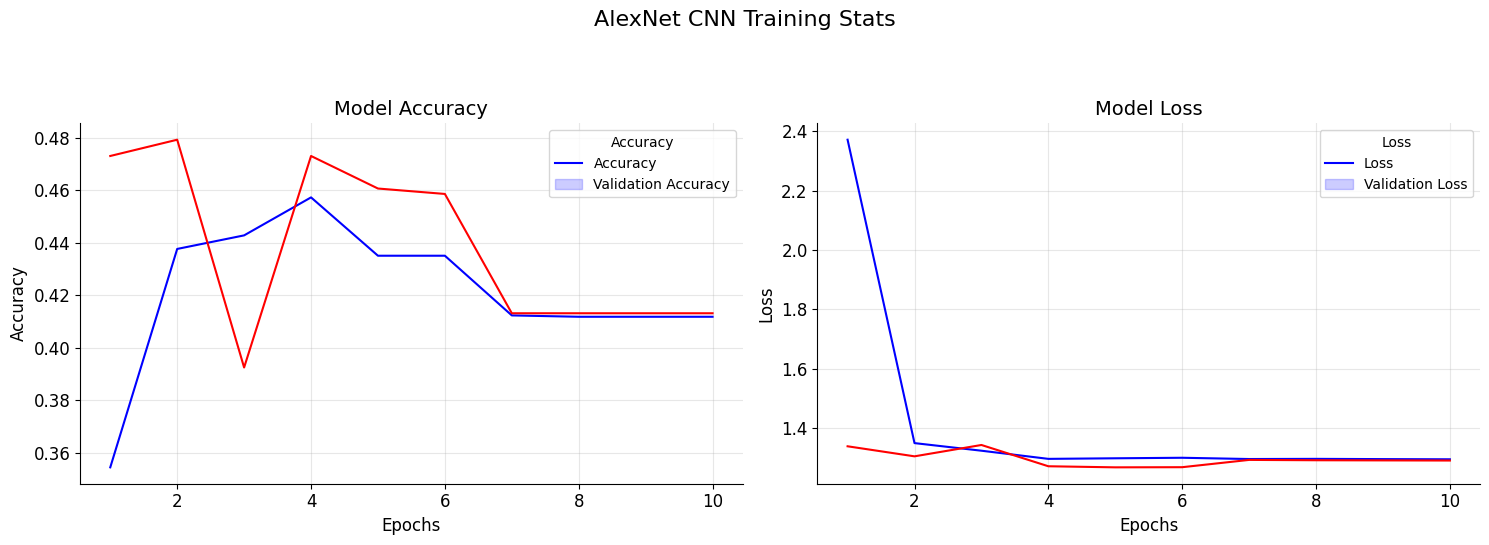

In [41]:
training_process_viz(pd.DataFrame(alexnet_train_history.history), plot_title = 'AlexNet CNN Training Stats')

33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step


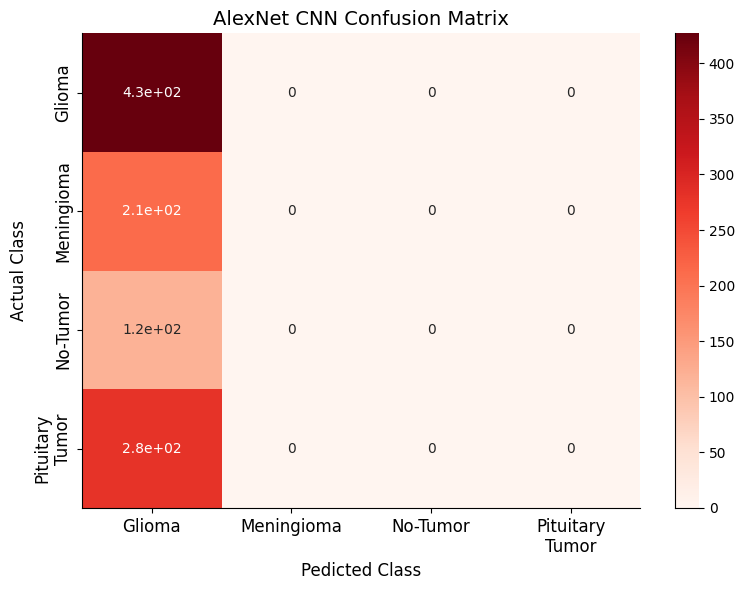

In [42]:
    confusion_matrix_viz(alexnet_cnn,
                         test_dataset,
                         plot_title = "AlexNet CNN Confusion Matrix")

In [43]:
alexnet_report_df = generate_report(alexnet_cnn, test_dataset = test_dataset, row_indexes = ['AlexNet CNN'])
alexnet_report_df

33/33 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.4000 - loss: 1.2996
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
AlexNet CNN,1.240848,3.082852,1.755805,1.292182,0.411368,0.411368


## **Inception V3**

In [44]:
inception_v3_model = InceptionV3(include_top = False,
                                 input_shape = (image_size, image_size, 3),
                                 pooling = 'avg')
inception_v3_model.trainable = False

In [45]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications.inception_v3 import InceptionV3

image_size = 224  # Define your image size here

inception_v3_model = InceptionV3(include_top = False,
                             input_shape = (image_size, image_size, 3),
                             pooling = 'avg')
inception_v3_model.trainable = False

inception_cnn_model = Sequential()
inception_cnn_model.add(inception_v3_model)
inception_cnn_model.add(Flatten())
inception_cnn_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-1'))
inception_cnn_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
inception_cnn_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Define an input shape before calling summary
input_shape = (1, image_size, image_size, 3)  # Assume batch size of 1
inception_cnn_model.build(input_shape=input_shape) # Build the model with a specific shape
inception_cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (1, 2048)                   │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (1, 2048)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (1, 1024)                   │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (1, 4)                      │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

**Training and Validation of InceptionV3 Model**

In [46]:
inception_model_train_history = inception_cnn_model.fit(train_dataset,
                                                            batch_size = batch_size,
                                                            validation_data = validation_dataset,
                                                            epochs = 100,
                                                            callbacks = [early_stopping, inceptionv3_cp_callback])

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5476 - loss: 1.9578
Epoch 1: saving model to /content/gdrive/MyDrive/Project/Model-Checkpoints/InceptionV3/model.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 437s 7s/step - accuracy: 0.5494 - loss: 1.9449 - val_accuracy: 0.7831 - val_loss: 0.5450
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7930 - loss: 0.5155
Epoch 2: saving model to /content/gdrive/MyDrive/Project/Model-Checkpoints/InceptionV3/model.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 429s 7s/step - accuracy: 0.7931 - loss: 0.5152 - val_accuracy: 0.7479 - val_loss: 0.6531
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8224 - loss: 0.4982
Epoch 3: saving model to /content/gdrive/MyDrive/Project/Model-Checkpoints/InceptionV3/model.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 446s 7s/step - accuracy: 0.8226 - loss: 0.4975 - val_accuracy: 0.8182 - val_loss: 0.5102
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8222 - loss: 0.4684
Epoc

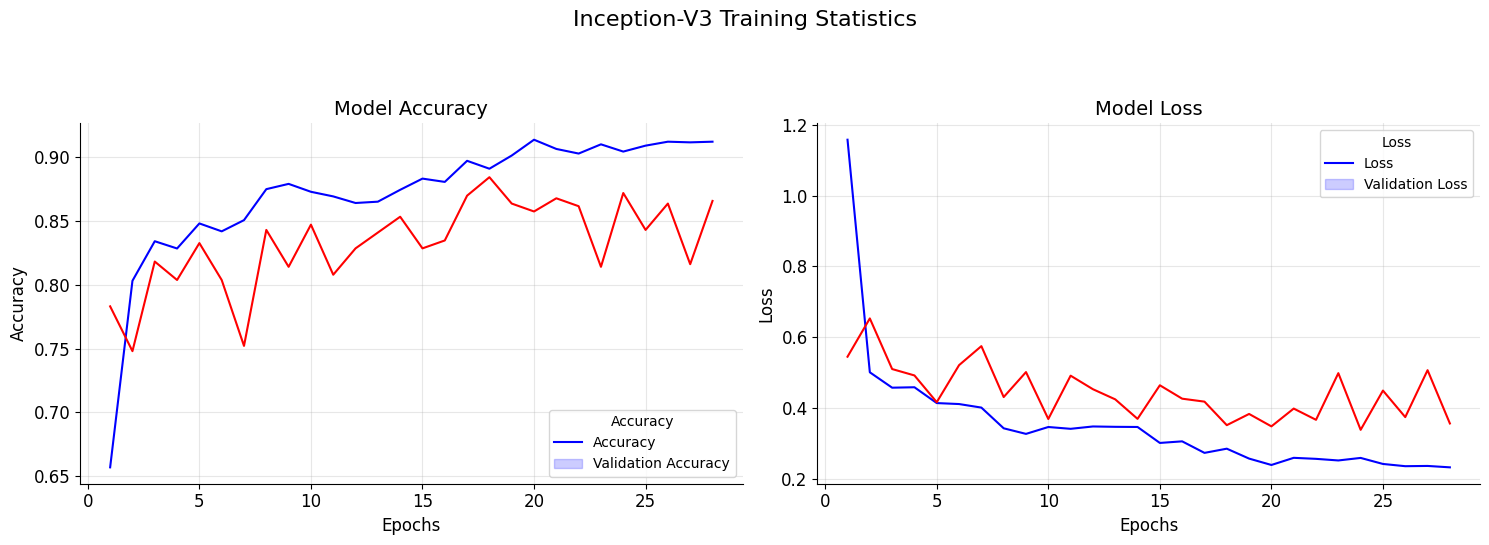

In [47]:
training_process_viz(pd.DataFrame(inception_model_train_history.history),
                     plot_title = 'Inception-V3 Training Statistics')

33/33 ━━━━━━━━━━━━━━━━━━━━ 184s 5s/step


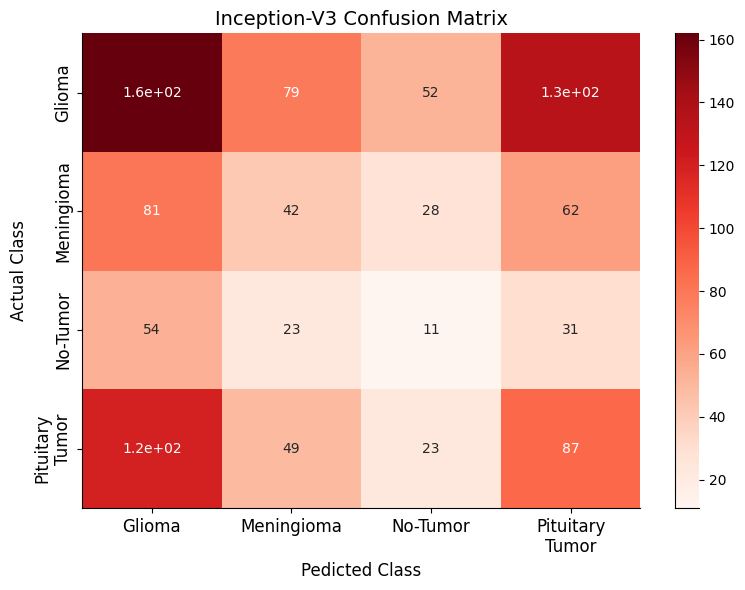

In [48]:
confusion_matrix_viz(inception_cnn_model,
                         test_dataset,
                         plot_title = "Inception-V3 Confusion Matrix")

In [49]:
inceptionv3_report_df = generate_report(inception_cnn_model, test_dataset = test_dataset, row_indexes = ['InceptionV3'])
inceptionv3_report_df

33/33 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - accuracy: 0.8806 - loss: 0.3448
33/33 ━━━━━━━━━━━━━━━━━━━━ 178s 5s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
InceptionV3,1.368979,3.172447,1.781136,0.31778,0.88632,0.298651


## **Final Insights Of the Project**

* The **pre-trained InceptionV3** model has performed the best among Multi-Layer perceptron and AlexNet CNN models with an accuracy of $88.63\%$ (Refer the following table).

In [50]:
final_report_df = pd.concat([mlp_report_df, alexnet_report_df, inceptionv3_report_df])
final_report_df

,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
Multi-Layer-Perceptron Model,1.374759,3.471098,1.863088,1.008680,0.610790,0.372832
AlexNet CNN,1.240848,3.082852,1.755805,1.292182,0.411368,0.411368
InceptionV3,1.368979,3.172447,1.781136,0.317780,0.886320,0.298651
